# 1D Heat Conduction Using PINNs

### Notes

**Model inputs:**
- `x` : position along the rod length under consideration (in m)
- `L` : length of the rod (in m)
- `side` : length of the cross-section of the rod (in m)

**Model output:**
- `T` : temperature of the rod at location `x` : normalized in range [0, 1]


### Discussion

**Input features:**
- Upon including more input features, such as $T_{wall},\ T_{inf},\ k$ and $h$, the model failed to converge. 
- This is likely due to the numerically large values of these variables as compared to $x,\ L$ and $s$. 
- Maybe min-max normalization of these variables could be helpful. 
- However, since the above parameters are not varying, it might not be very meaningful to include them as input features.

**Output Features:**
- Including other outputs such as $\alpha = k A_{cs}$ and $\beta = h P$ is also not useful since these are constants.


### Recommendation from ChatGPT:

- **Activation Functions:** Using smooth activations like `Tanh` is common in PINNs because they yield smooth derivatives, which is important when computing higher-order derivatives for the PDE residual. `ReLU`, while popular in many applications, has a non-differentiable point at zero and can yield zero gradients in some regions; this might hinder training when the network needs to produce accurate second derivatives.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Set device (use GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') # since the network is small, cpu will suffice
print(device)


cpu


**Set random generator seed for consistency:**

In [3]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    print(f"torch.cuda.manual_seed_all set to : {seed}")


torch.cuda.manual_seed_all set to : 42


## Initialize Parameters

**Min-max Normalization:**
- Scales features in the range of [0, 1]

$$ x_{norm} = \frac{ x - x_{min} }{ x_{max} - x_{min} } $$


**Temperature Normalization:**
$$ T_{norm} = \frac{ T - T_{inf} }{ T_{wall} - T_{inf} } $$

**Temperature De-normalization:**
$$ T = T_{norm} \times ( T_{wall} - T_{inf} ) + T_{inf} $$

In [4]:
# Given parameters
T_wall = 100.0     # left wall temperature [°C]
T_inf = 10.0       # ambient temperature [°C]
L = 0.5            # rod length [m]
k = 400.0          # thermal conductivity [W/m.K]
h = 10.0           # convective heat transfer coefficient [W/m^2.K]

# Cross-sectional properties (square: 0.01 m x 0.01 m)
s   = 0.01      # [m]
A   = s**2   # cross-sectional area [m^2]
P   = 4*s    # perimeter [m]

# Discretization:
dx = 0.01 # [m]
num_nodes = int(L/dx) + 1

# Create the positions as a tensor (shape: [101, 1])
x_coord = torch.linspace(0, L, num_nodes, requires_grad=True, device=device).view(-1, 1)
X = x_coord

print("dx    =", dx, "m")
print("nodes =", num_nodes)



dx    = 0.01 m
nodes = 51


In [5]:
########################
# # Try have more input features
# # - need to change the number of input neurons in network-architecture 
# # - Did NOT show much improvement
########################

# # For the constant parameters L and side, create tensors (same shape as x)
# L_tensor    = torch.full_like(x_coord, L)
# side_tensor = torch.full_like(x_coord, s)

# # Concatenate to form the input vector: each row = [x, L, side]
# X = torch.cat((x_coord, L_tensor, side_tensor), dim=1)
# X.to(device)


## PINNs

In [6]:
# Define the neural network (a simple feed-forward MLP)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, X):
        return self.net(X)


**Weights Initialization**

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


## Training

**Temperature De-normalization:**
$$ T = T_{norm} \times ( T_{wall} - T_{inf} ) + T_{inf} $$

In [8]:
# Model Initialization
model = PINN().to(device)
model.apply(init_weights)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Learning-rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# loss coefficients
loss_coeff_1 = 1
loss_coeff_2 = 10
loss_coeff_3 = 100

# Number of training epochs
num_epochs = 25000
print("#" * 17)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: predict T for all collocation points
    T_pred_norm = model(X)  # normalize output in range [0, 1]
    T_pred      = T_pred_norm*(T_wall - T_inf) + T_inf # de-normalization

    # --- Compute derivatives using autograd ---
    dTdx = torch.autograd.grad(outputs=T_pred, inputs=x_coord,
                           grad_outputs=torch.ones_like(T_pred),
                           create_graph=True)[0]
    
    
    d2Tdx2 = torch.autograd.grad(outputs=dTdx, inputs=x_coord,
                                grad_outputs=torch.ones_like(dTdx),
                                create_graph=True)[0]
    
    # --- Loss computation ---
    # 1. Left boundary:
    loss_left = loss_coeff_1 * (T_pred[0] - T_wall)**2
    
    # 2. Interior points: enforce PDE at interior collocation points (exclude endpoints)
    interior        = slice(1, -1)
    f_interior      = d2Tdx2[interior] - (h*P / (k*A)) * (T_pred[interior] - T_inf)
    loss_interior   = loss_coeff_2 * torch.mean(f_interior**2)
    
    # 3. Right boundary:
    f_right     = k*A*dTdx[-1] + h*A*(T_pred[-1] - T_inf)
    loss_right  = loss_coeff_3 * f_right**2
    
    # Total loss
    loss = loss_left + loss_interior + loss_right
    loss.backward()
    optimizer.step()
    
    # nly: For learning-rate dacay 
    # Step the scheduler at the end of the epoch
    scheduler.step()

    if epoch == 0 or (epoch + 1) % 5000 == 0:
        print(f"Epoch {epoch+1}")
        print(f"Total Loss    = {loss.item():.6f}")
        print(f"loss_left     = {loss_left.item():.4f}")
        print(f"loss_interior = {loss_interior.item():.4f}")
        print(f"loss_right    = {loss_right.item():.4f}")
        print("#" * 17)



#################
Epoch 1
Total Loss    = 16105.522461
loss_left     = 8100.0000
loss_interior = 7983.7891
loss_right    = 21.7337
#################
Epoch 5000
Total Loss    = 365.664551
loss_left     = 66.5346
loss_interior = 63.4657
loss_right    = 235.6642
#################
Epoch 10000
Total Loss    = 115.582939
loss_left     = 1.0943
loss_interior = 103.2476
loss_right    = 11.2410
#################
Epoch 15000
Total Loss    = 18.121021
loss_left     = 0.5496
loss_interior = 14.6009
loss_right    = 2.9705
#################
Epoch 20000
Total Loss    = 11.380406
loss_left     = 0.1450
loss_interior = 10.5254
loss_right    = 0.7100
#################
Epoch 25000
Total Loss    = 7.609323
loss_left     = 0.0630
loss_interior = 7.2470
loss_right    = 0.2994
#################


## Result Visualization

**Learning Rate Value:**

In [9]:
print(optimizer.param_groups[0]['lr']) # = 0.01 * 0.9^25


0.0007178979876918532


**Model Prediction**

In [10]:
# Evaluate the trained model
with torch.no_grad():
    T_solution_norm = model(X).cpu().numpy().flatten()
    T_solution = T_solution_norm*(T_wall - T_inf) + T_inf
    x_np = x_coord.cpu().numpy().flatten()

print(f'Temperature at left boundary  : {T_solution[0]:.3f} deg C')
print(f'Temperature at right boundary : {T_solution[-1]:.3f} deg C')


Temperature at left boundary  : 99.749 deg C
Temperature at right boundary : 44.785 deg C


## FDM Solution

In [11]:
from utils_HT_1D_FDM import HT_1D_FDM

x_fdm, T_fdm = HT_1D_FDM(L, s)
print(f'T at right boundary : {T_fdm[-1]:.3f} deg C')


T at right boundary : 45.275 deg C


## Compare PINNs with FDM 

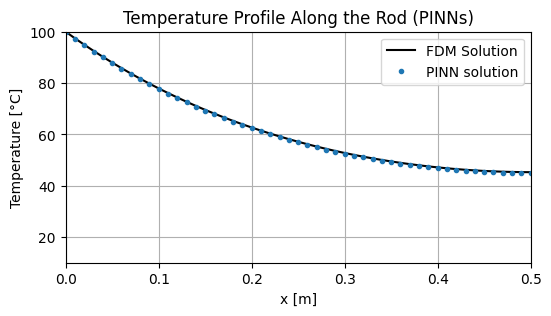

In [12]:
# Plot the temperature profile (line plot)
plt.figure(figsize=(6, 3))
plt.plot(x_fdm, T_fdm, '-k', label='FDM Solution')
plt.plot(x_np, T_solution, '.', label='PINN solution')

plt.xlabel('x [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature Profile Along the Rod (PINNs)')
plt.axis([0, L, T_inf, T_wall])
plt.legend()
plt.grid(True)
plt.show()
